In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout
#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier, KerasRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score


In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
X = train.drop('Survived', axis=1)
y = train['Survived']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [5]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
531,532,3,"Toufik, Mr. Nakli",male,NaN,0,0,2641,7.2292,NaN,C
519,520,3,"Pavlovic, Mr. Stefo",male,32.0,0,0,349242,7.8958,NaN,S
791,792,2,"Gaskell, Mr. Alfred",male,16.0,0,0,239865,26.0000,NaN,S
235,236,3,"Harknett, Miss. Alice Phoebe",female,NaN,0,0,W./C. 6609,7.5500,NaN,S
240,241,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C


In [6]:
class CategoricalFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.common_titles = []
        self.common_ticket_alphas = []
        pass
    def fit(self, X, y = None):
        titles = [name.split(' ')[1] for name in X['Name']]
        counts = {title: titles.count(title) for title in set(titles)}
        counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
        self.common_titles = [title for i, title in enumerate(counts.keys()) if i < 5]
        
        ticket_alphas = [''.join(i for i in ticket if i.isalpha()).upper() for ticket in X['Ticket']]
        ticket_alphas = [ticket_alpha if ticket_alpha != '' else 'None' for ticket_alpha in ticket_alphas]
        counts = {ticket_alpha: ticket_alphas.count(ticket_alpha) for ticket_alpha in set(ticket_alphas)}
        counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
        self.common_ticket_alphas = [ticket_alpha for i, ticket_alpha in enumerate(counts.keys()) if i < 5]
        return self
    def transform(self, X, y = None):
        X_new = X.copy(deep=True)
        titles = [name.split(' ')[1] for name in X['Name']]
        X_new['title'] = [title if title in self.common_titles else np.nan for title in titles]
        X_new.drop('Name', axis=1, inplace=True)
        ticket_alphas = [''.join(i for i in ticket if i.isalpha()).upper() for ticket in X['Ticket']]
        ticket_alphas = [ticket_alpha if ticket_alpha != '' else 'None' for ticket_alpha in ticket_alphas]
        X_new['ticket_alpha'] = [ticket_alpha if ticket_alpha in self.common_ticket_alphas 
                                 else "NA" for ticket_alpha in ticket_alphas]
        X_new.drop('Ticket', axis=1, inplace=True)
        cabins = [str(i)[0].upper() for i in X['Cabin']]
        X_new['Cabin'] = [cabin if cabin in ['A','B','C','D','E'] else "Unknown" for cabin in cabins]
        return X_new
        

In [7]:
cfa = CategoricalFeatureAdder()
cfa.fit_transform(X_train[['Name', 'Sex', 'Embarked', 'Ticket', 'Cabin']])

,Sex,Embarked,Cabin,title,ticket_alpha
531,male,C,Unknown,Mr.,None
519,male,S,Unknown,Mr.,None
791,male,S,Unknown,Mr.,None
235,female,S,Unknown,Miss.,NA
240,female,C,Unknown,Miss.,None
...,...,...,...,...,...
629,male,Q,Unknown,Mr.,None
130,male,C,Unknown,Mr.,None
347,female,S,Unknown,Mrs.,None
546,female,S,Unknown,Mrs.,None


In [11]:
cat_pipeline = Pipeline([
    ('feature_engineering', CategoricalFeatureAdder()),
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('one-hot', OneHotEncoder()),
])

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())])

ct = ColumnTransformer(
    [('numerical_pipeline', num_pipeline, ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
     ('categorical_pipeline', cat_pipeline, ['Name', 'Sex', 'Embarked', 'Ticket', 'Cabin'])])

n_cols = np.size(ct.fit_transform(X_train), axis=1)

clf_name = "SVC"

if clf_name == 'rf':
    clf = RandomForestClassifier(random_state=42)
    params = {"clf__max_depth": range(5, 8),
              "clf__n_estimators": range(60, 100, 10)}
elif clf_name == 'SVC':
    clf = SVC()
    params = {'clf__C': [1],
              'clf__gamma': [0.1]}
    # params = {'model__C': [0.1,1, 10, 100], 
    #           'model__gamma': [1,0.1,0.01,0.001],
    #           'model__kernel': ['rbf', 'poly', 'sigmoid']}
elif clf_name == "nn":
    def create_model(dropout, kernel_initializer, epochs=4, optimizer='adagrad'):
        model = Sequential()
        model.add(Dense(64,activation='relu', input_shape=(n_cols,)))
        model.add(Dropout(dropout))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(dropout))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(dropout))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
        return model
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    clf = KerasClassifier(create_model, epochs=4, dropout=0.2, kernel_initializer='glorot_uniform', verbose=0,
                          callbacks=[early_stopping])
    params = {
    'clf__optimizer':['rmsprop'],
    'clf__epochs':[16],
    'clf__dropout':[0.2],
    'clf__kernel_initializer':['glorot_uniform']
    }
else:
    clf = KNeighborsClassifier()
    params = {"clf__n_neighbors": [3,4,5,6,7]}

full_pipeline = Pipeline([
    ('preprocessing', ct),
    ('clf', clf)
])

cv = GridSearchCV(full_pipeline, param_grid=params, scoring='accuracy', verbose=True)

hist = cv.fit(X_train, y_train)
y_pred = cv.predict(X_valid)

print(f"Classifier: {clf} Accuracy: {100 * accuracy_score(y_valid, y_pred):.2f}%")
print(cv.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Classifier: SVC() Accuracy: 79.89%
{'clf__C': 1, 'clf__gamma': 0.1}


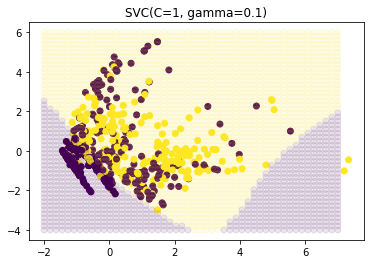

In [12]:
best_params = {item[0].split("__")[1]: item[1] for item in cv.best_params_.items()}
if clf_name == 'rf':
    clf = RandomForestClassifier(random_state=42, **best_params)
elif clf_name == 'SVC':
    clf = SVC(**best_params)
else:
    clf = KNeighborsClassifier(**best_params)

X_train_prepped = ct.fit_transform(X_train)
clf.fit(X_train_prepped, y_train)

pca = PCA(2)
X_train_2D = pca.fit_transform(X_train_prepped)
x1 = X_train_2D[:, 0]
x2 = X_train_2D[:, 1]
fig = plt.figure()
plt.scatter(x1, x2, c=y_train, cmap='viridis')

x1_vals = np.linspace(-2, 7, 50)
x2_vals = np.linspace(-4, 6, 50)
grid = np.meshgrid(x1_vals, x2_vals)
predictions = np.zeros((len(x1_vals), len(x2_vals)))
for i, x1_val in enumerate(x1_vals):
    for j, x2_val in enumerate(x2_vals):
        prediction = clf.predict([x1_val*pca.components_[0] + x2_val*pca.components_[1]])
        predictions[i][j] = prediction
plt.scatter(grid[:][0], grid[:][1], c = predictions, alpha=0.1)
plt.title(clf)
plt.show()